In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d nirmalsankalana/sugarcane-leaf-disease-dataset


Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/sugarcane-leaf-disease-dataset
License(s): CC0-1.0
 93% 149M/160M [00:01<00:00, 115MB/s]
100% 160M/160M [00:01<00:00, 93.4MB/s]


In [2]:
! unzip /content/sugarcane-leaf-disease-dataset.zip

Archive:  /content/sugarcane-leaf-disease-dataset.zip
  inflating: Healthy/healthy (1).jpeg  
  inflating: Healthy/healthy (10).jpeg  
  inflating: Healthy/healthy (100).jpeg  
  inflating: Healthy/healthy (101).jpeg  
  inflating: Healthy/healthy (102).jpeg  
  inflating: Healthy/healthy (103).jpeg  
  inflating: Healthy/healthy (104).jpeg  
  inflating: Healthy/healthy (105).jpeg  
  inflating: Healthy/healthy (106).jpeg  
  inflating: Healthy/healthy (107).jpeg  
  inflating: Healthy/healthy (108).jpeg  
  inflating: Healthy/healthy (109).jpeg  
  inflating: Healthy/healthy (11).jpeg  
  inflating: Healthy/healthy (110).jpeg  
  inflating: Healthy/healthy (111).jpeg  
  inflating: Healthy/healthy (112).jpeg  
  inflating: Healthy/healthy (113).jpeg  
  inflating: Healthy/healthy (114).jpeg  
  inflating: Healthy/healthy (115).jpeg  
  inflating: Healthy/healthy (116).jpeg  
  inflating: Healthy/healthy (117).jpeg  
  inflating: Healthy/healthy (118).jpeg  
  inflating: Healthy/healt

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [5]:
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
DATASET_DIR = "/content/sugarcane-leaf-disease-dataset"
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 250
FINE_TUNE_POINT = 125
LEARNING_RATE = 0.001

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

Found 2521 files belonging to 5 classes.
Using 2017 files for training.
Found 2521 files belonging to 5 classes.
Using 504 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

In [9]:
for example_image, example_label in train_ds.take(1):
  break

print(f"Image Shape: {example_image.shape}")

Image Shape: (32, 128, 128, 3)


In [10]:
validation_ds = validation_ds.shard(num_shards=2, index=0)
test_ds = validation_ds.shard(num_shards=2, index=1)

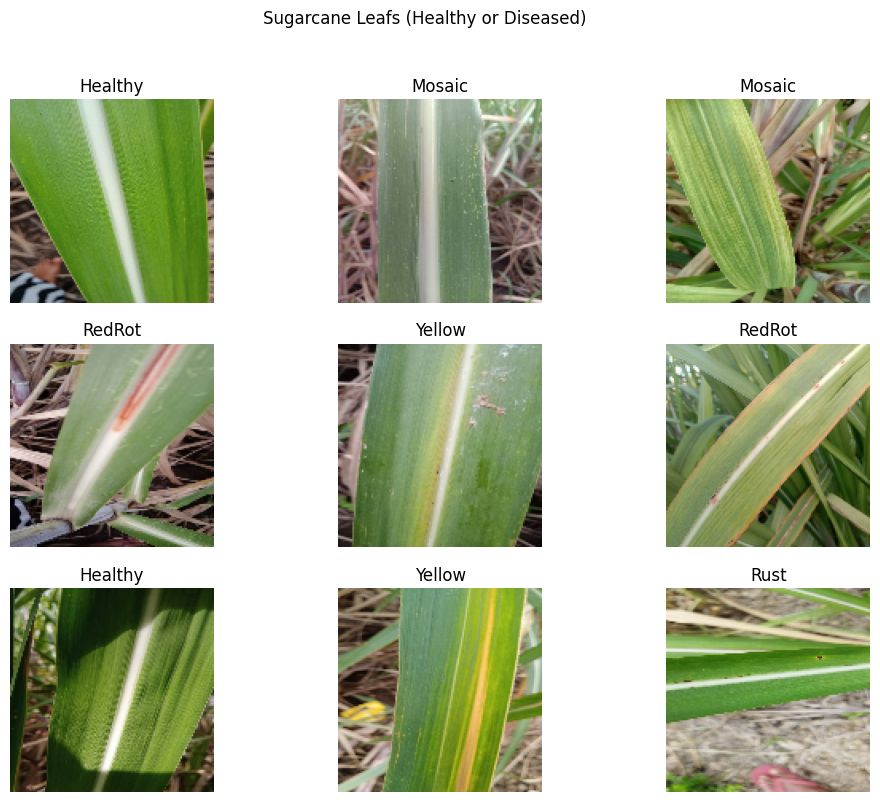

In [11]:
plt.figure(figsize=(12, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
        plt.axis("off")

In [12]:
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

print(len(base_model.layers))

9406464/9406464 [==============================] - 0s 0us/step
154


In [14]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
  layer.trainable = False

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
)

Epoch 1/50
64/64 [==============================] - 29s 95ms/step - loss: 0.8105 - accuracy: 0.7224 - val_loss: 4.6135 - val_accuracy: 0.4609
Epoch 2/50
64/64 [==============================] - 2s 25ms/step - loss: 0.2642 - accuracy: 0.9088 - val_loss: 3.3826 - val_accuracy: 0.6133
Epoch 3/50
64/64 [==============================] - 2s 26ms/step - loss: 0.2476 - accuracy: 0.9212 - val_loss: 5.2233 - val_accuracy: 0.5156
Epoch 4/50
64/64 [==============================] - 2s 27ms/step - loss: 0.1858 - accuracy: 0.9435 - val_loss: 7.7007 - val_accuracy: 0.4336
Epoch 5/50
64/64 [==============================] - 2s 25ms/step - loss: 0.1467 - accuracy: 0.9564 - val_loss: 9.7962 - val_accuracy: 0.4531
Epoch 6/50
64/64 [==============================] - 2s 24ms/step - loss: 0.0973 - accuracy: 0.9737 - val_loss: 7.8607 - val_accuracy: 0.5625
Epoch 7/50
64/64 [==============================] - 2s 24ms/step - loss: 0.0943 - accuracy: 0.9678 - val_loss: 3.3860 - val_accuracy: 0.7070
Epoch 8/50
6

Text(0.5, 0, 'Epoch')

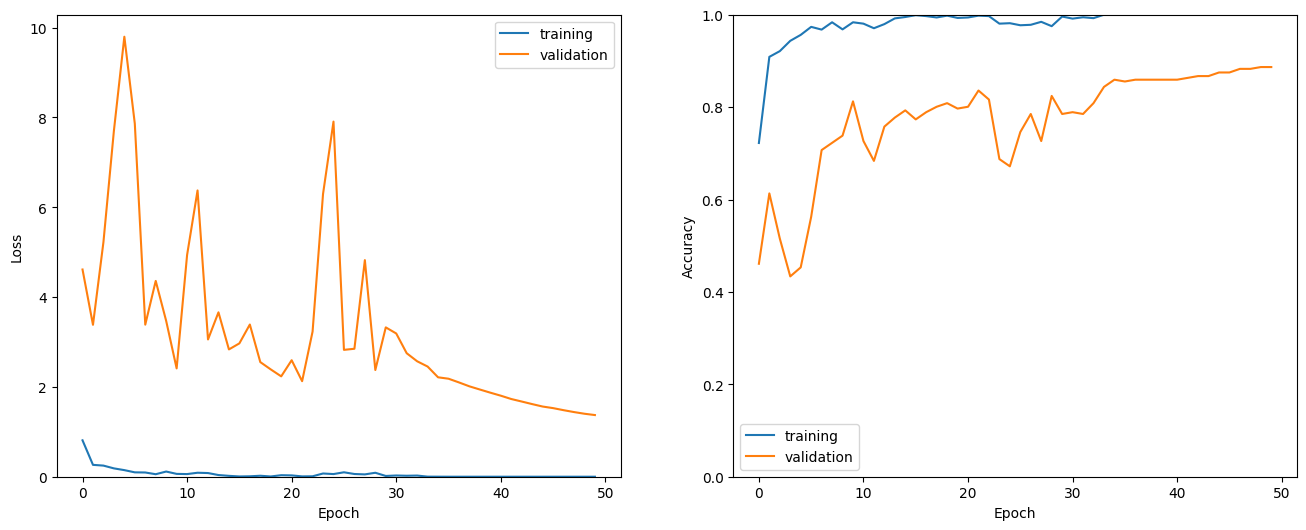

In [18]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [19]:
keras.saving.save_model(model,"seker_kamisi_hastaligi.hdf5")
print("seker_kamisi_hastaligi.hdf5 Model Kayıt Edildi")

<ipython-input-19-7f3bad2d3f47>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.saving.save_model(model,"seker_kamisi_hastaligi.hdf5")


seker_kamisi_hastaligi.hdf5 Model Kayıt Edildi


In [20]:
del model

In [22]:
! kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 93% 150M/161M [00:01<00:00, 133MB/s]
100% 161M/161M [00:01<00:00, 107MB/s]


In [23]:
! unzip /content/corn-or-maize-leaf-disease-dataset.zip

Archive:  /content/corn-or-maize-leaf-disease-dataset.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Blight/Corn_Blight (101).jpg  
  inflating: data/Blight/Corn_Blight (1010).JPG  
  inflating: data/Blight/Corn_Blight (1011).jpg  
  inflating: data/Blight/Corn_Blight (1012).JPG  
  inflating: data/Blight/Corn_Blight (1013).JPG  
 

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [25]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [26]:
len(dataset)

131

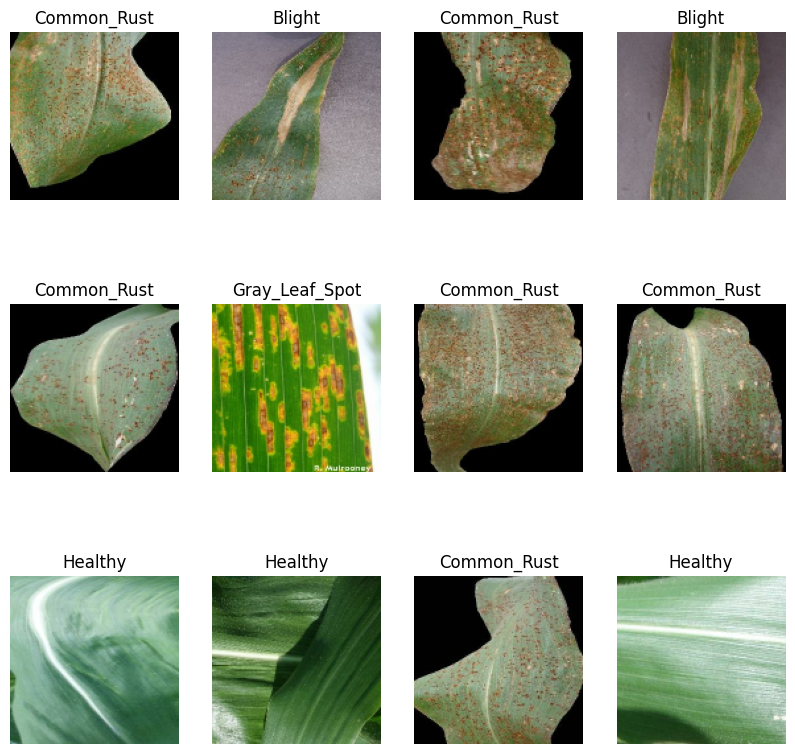

In [27]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [28]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [29]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [30]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 104

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
from tensorflow.keras import models,layers
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [35]:
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [37]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [38]:
history = model.fit(
train_ds,
epochs=40,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/40
104/104 [==============================] - 27s 136ms/step - loss: 0.6977 - accuracy: 0.7178 - val_loss: 0.4234 - val_accuracy: 0.8293
Epoch 2/40
104/104 [==============================] - 6s 55ms/step - loss: 0.4364 - accuracy: 0.8213 - val_loss: 0.5236 - val_accuracy: 0.8125
Epoch 3/40
104/104 [==============================] - 6s 53ms/step - loss: 0.4113 - accuracy: 0.8288 - val_loss: 0.4074 - val_accuracy: 0.8365
Epoch 4/40
104/104 [==============================] - 6s 54ms/step - loss: 0.3992 - accuracy: 0.8330 - val_loss: 0.3313 - val_accuracy: 0.8798
Epoch 5/40
104/104 [==============================] - 6s 53ms/step - loss: 0.3853 - accuracy: 0.8415 - val_loss: 0.3098 - val_accuracy: 0.8750
Epoch 6/40
104/104 [==============================] - 6s 55ms/step - loss: 0.3428 - accuracy: 0.8496 - val_loss: 0.3215 - val_accuracy: 0.8726
Epoch 7/40
104/104 [==============================] - 6s 53ms/step - loss: 0.3446 - accuracy: 0.8511 - val_loss: 0.2896 - val_accuracy: 0.87

Text(0.5, 0, 'Epoch')

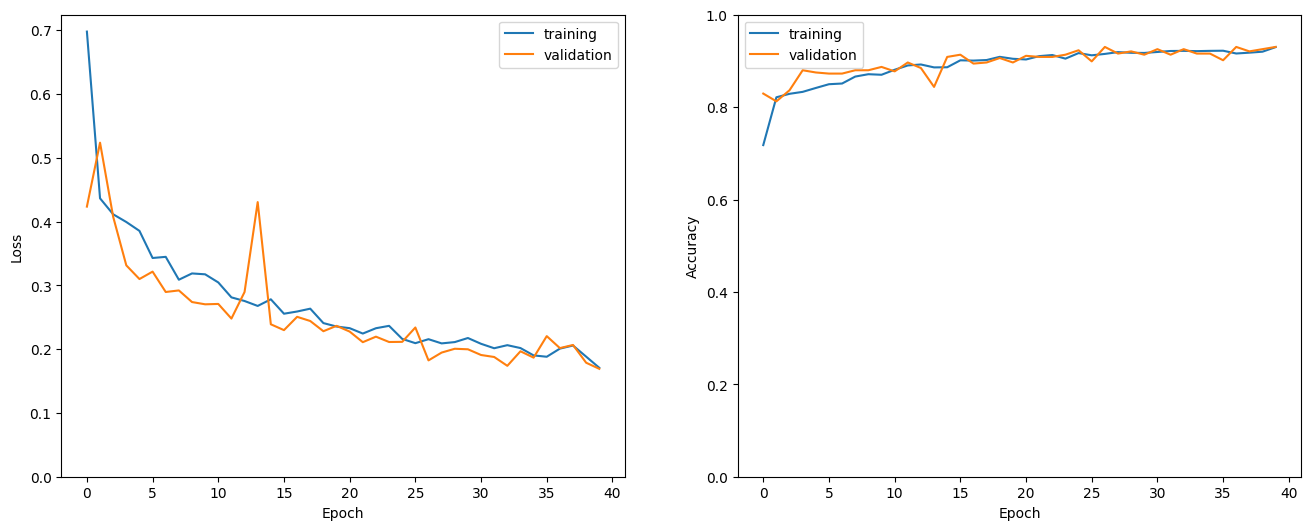

In [39]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [40]:
keras.saving.save_model(model,"misir_yapragi_hastaligi.hdf5")
print("misir_yapragi_hastaligi.hdf5 Model Kayıt Edildi")

misir_yapragi_hastaligi.hdf5 Model Kayıt Edildi


<ipython-input-40-b082b1790490>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.saving.save_model(model,"misir_yapragi_hastaligi.hdf5")


In [41]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [55]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

def load_seker_kamisi_model():
  model=tf.keras.models.load_model("/content/seker_kamisi_hastaligi.hdf5")
  return model
def load_misir_yapragi_model():
  model=tf.keras.models.load_model("/content/misir_yapragi_hastaligi.hdf5")
  return model

def prediction_misir(image,model):
  image=tf.cast(image,tf.float32)
  image=tf.image.resize(image,[256,256])
  image=np.expand_dims(image,axis=0)
  prediction=model.predict(image)
  return prediction

def prediction_seker(image,model):
  image=tf.cast(image,tf.float32)
  image=tf.image.resize(image,[128,128])
  image=np.expand_dims(image,axis=0)
  prediction=model.predict(image)
  return prediction
sekermodel=load_seker_kamisi_model()
misirmodel=load_misir_yapragi_model()


Overwriting app.py


In [56]:
%%writefile -a app.py
rad= st.sidebar.radio("Menu",["Home","Seker Kamisi Hastaligi","Misir Yapragi Hastaligi"])

#Anasayfa
if rad=="Home":
  st.title("201505032 Kerim Berkay Buçan")
  st.text("Aşağıdaki datasetler üzerine karar destek sistemi oluşturulacaktır")
  st.text("1.Seker Kamisi Hastaligi Tespiti")
  st.text("2.Misir Yapragi Hastaligi")


Appending to app.py


In [57]:
%%writefile -a app.py
if rad=="Seker Kamisi Hastaligi":
  st.header("Seker Kamisi Hastaligi Tespiti")
  file=st.file_uploader("Bir Seker Kamisi Resmi Yükleyiniz",type=["jpg","png"])

  if file is None:
    st.warning("Resim Yükleyiniz...")
  else:
    slot=st.empty()
    slot.text("Görüntü İşlem Yapılıyor..")
    test_image=Image.open(file)
    st.image(test_image,caption="Input Image",width=400)
    pred=prediction_seker(np.asarray(test_image),sekermodel)
    class_names= ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
    sonuc=class_names[np.argmax(pred)]
    cikis="yüklenen resmin sınıfı :", sonuc
    slot.text("İşlem Tamamlandı")
    st.success(cikis)

Appending to app.py


In [58]:
%%writefile -a app.py
if rad=="Misir Yapragi Hastaligi":
  st.header("Misir Yapragi  Hastaligi Tespiti")
  file2=st.file_uploader("Bir Misir Yapragi  Resmi Yükleyiniz",type=["jpg","png"])

  if file2 is None:
    st.warning("Resim Yükleyiniz...")
  else:
    slot=st.empty()
    slot.text("Görüntü İşlem Yapılıyor..")
    test_image=Image.open(file2)
    st.image(test_image,caption="Input Image",width=400)
    pred=prediction_seker(np.asarray(test_image),misirmodel)
    class_names= ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
    sonuc=class_names[np.argmax(pred)]
    cikis="yüklenen resmin sınıfı :", sonuc
    slot.text("İşlem Tamamlandı")
    st.success(cikis)

Appending to app.py


In [59]:
!wget -q -O - ipv4.icanhazip.com

34.105.126.123


In [60]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.105.126.123:8501

npx: installed 22 in 1.855s
your url is: https://silly-files-help.loca.lt
2024-05-11 13:44:52.665305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 13:44:52.665356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 13:44:52.667055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 13:44:54.242034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-11 13:44:55.98155

In [ ]:
tf.__version__

'2.12.0'